In [1]:
import cobra
import PyDSTool as dst
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
model = cobra.io.read_sbml_model('./data/Bacteroides_sp_1_1_14.xml')
mediaFluxes = pd.read_csv('./data/VMH_HighFiber.tsv', sep='\t')

# Extract exchange reactions into variable definition and ics dictionary

In [75]:
def cleanupname(name):
    """
    The reaction names in the model files 
    don't have brackets or parentheses. I replaced
    those found in the mediaFluxes file.
    """
    name = name.replace('[', '_LPAREN_')
    name = name.replace(']', '_RPAREN_')
    name = name.replace('(', '_LPAREN_')
    name = name.replace(')', '_RPAREN_')
    return name

"""
Initialize dictionaries for defining the ODE variables for a 
single species
"""

VarDef = dict()
ParDef = dict()
ICS = dict()

solution = model.optimize() # Get fluxes
all_exchanges = model.exchanges
media_derived_components = dict()

exchange_reaction_ids = [rxn.id for rxn in all_exchanges]

"""
Extract the reaction names and flux values into
a dictionary
"""
for i, row in mediaFluxes.iterrows():
    N = cleanupname(row.Reaction)
    if N in exchange_reaction_ids:
        media_derived_components[N] = row['Flux Value'] / (24.0*60.0) # Per minute

"""
Get the outfluxes
"""
out_fluxes = []
for k in all_exchanges:
    if k.reversibility and k.id not in media_derived_components.keys():
        out_fluxes.append(k.id)

ParDef['Dilution'] = 0.00385 # half life of 3 hours
VarDef['X'] = str(solution.objective_value/60.0) + '* X'
ICS['X'] = 1.0
for r in all_exchanges:
    if r.id in media_derived_components.keys():
        ParDef[r.id + '_influx'] = media_derived_components[r.id]
        ParDef[r.id + '_consumption'] = solution.fluxes[r.id]
        ICS[r.id] = media_derived_components[r.id]
        VarDef[r.id] = r.id + '_influx + ' + r.id + '_consumption' + '* X *' + r.id
    if r.id in out_fluxes:
        ParDef[r.id + '_outflux'] = solution.fluxes[r.id] 
        VarDef[r.id] = r.id + '_outflux * X'
        ICS[r.id] = 0.0

In [89]:
ModelDef = dst.args(name='Bacteroides',
                   varspecs=VarDef,
                   ics=ICS,
                   pars=ParDef,
                   tdata=[0,100])

ModelDS = dst.Vode_ODEsystem(ModelDef)
P = ModelDS.compute('test').sample()

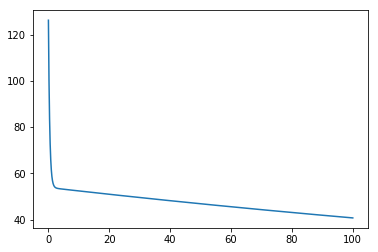

In [91]:
# for k in media_derived_components.keys():
#     plt.plot(P['t'], P[k],label=k)
# for k in out_fluxes:
#     plt.plot(P['t'], P[k], label=k)
plt.plot(P['t'], P['EX_h2o_LPAREN_e_RPAREN_'],)

plt.legend()
plt.show()

In [92]:
solution.fluxes['EX_2obut_LPAREN_e_RPAREN_']

-1.0

In [72]:
np.log(2)/180

0.0038508176697774738